In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
from sklearn.decomposition import PCA

# Sistemas de Recomendação

O que é um sistema de recomendação? Um sistema de recomendação é um algoritmo que busca, a partir do comportamento histórico de um conjunto de usuários, fazer recomedações de comportamentos futuros. Essa definição abrangente mostra como essa classe de algoritmos de ML tem uma enormidade de diferentes aplicações:

* **Redes Socias**: sistemas de recomendação estão por trás de varias partes de qualquer rede social, da sugestão de novas amizades à decisão de quais updates mostrar no feed principal do usuáriostão por trás de varias partes de qualquer rede social, da sugestão de novas amizades à decisão de quais updates mostrar no feed principal do usuário;
* **eCommerce**: junto com as redes sociais foram um dos pioneiros da adoção de sistemas de recomendação, onde são utilizados para gerar ofertas customizadas de produtos para cada usuário;
* **Serviços de Streaming**: assim como os sistemas de ecommerce, as plataformas de streaming buscam aumentar a fidelidade do cliente fazendo sugestões de novos conteúdos que podem interessar ao usuário através de sistemas de recomendação;
* **Corretores de Texto**: muitos corretores de texto em plataforma mobile utilizam algoritmos semelhantes à sistemas de recomendação para otimizar as sugestões de correção para cada usuário.

Como podemos ver, o campo de aplicação destes algoritmos é enorme. Hoje vamos analisar uma utilização particular mas que pode ser extendida para diversos tipos diferentes de problemas.

## Construindo a matriz usuário-item

Vamos retomar um problema antigo para explorar a construção de um sistema de recomendação: vamos analisar os dados de sellers a categorias da Olist.

In [4]:
tb_seller_cat = pd.read_csv('data/tb_seller_cat_olist.csv')

Para testarmos um modelo de recomendação precisamos utilizar uma estratégia um pouco diferente da que implementamos até agora e que será muito complexa de implantarmos utilizando apenas `pandas` e `sklearn` - veremos como fazer a validação usando a biblioteca `surprise` ao final da aula.

O ponto de partida fundamental de qualquer modelo de recomendação é a matriz de item-usuário - essa matriz contém os usuários nas linhas e os itens nas colunas. Como dado, teremos o valor binário se o usuário compra o item.

No nosso caso o usuário é o seller, os itens são as categorias dos produtos, e a matriz contém a informação binária de se o seller vende ou não a categoria.

In [5]:
tb_seller_cat['vende_cat'] = np.where(tb_seller_cat['rb'] > 0, 1, 0)
tb_seller_cat.head()

,seller_id,product_category_name,rb,vende_cat
0,66dc1b1632bd6a3e508510c5b3492107,automotivo,895.80,1
1,4e42581f08e8cfc7c090f930bac4552a,moveis_decoracao,109.00,1
2,2c9e548be18521d1c43cde1c582c6de8,artigos_de_festas,109.00,1
3,a673821011d0cec28146ea42f5ab767f,cama_mesa_banho,10182.46,1
4,59cea8e446d3834393058e7e0666b6fb,informatica_acessorios,159.60,1


In [6]:
tb_seller = tb_seller_cat.pivot_table(values = 'vende_cat', index = 'seller_id', columns = 'product_category_name', aggfunc = 'sum', fill_value = 0).reset_index()
tb_seller.head()

product_category_name,seller_id,agro_industria_e_comercio,alimentos,alimentos_bebidas,artes,artes_e_artesanato,artigos_de_festas,artigos_de_natal,audio,automotivo,...,pet_shop,portateis_casa_forno_e_cafe,portateis_cozinha_e_preparadores_de_alimentos,relogios_presentes,seguros_e_servicos,sinalizacao_e_seguranca,tablets_impressao_imagem,telefonia,telefonia_fixa,utilidades_domesticas
0,0015a82c2db000af6aaaf3ae2ecb0532,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,001cca7ae9ae17fb1caed9dfb1094831,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,001e6ad469a905060d959994f1b41e4f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,002100f778ceb8431b7a1020ff7ab48f,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,004c9cd9d87a3c30c522c48c4fc07416,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
tb_seller.columns

Index(['seller_id', 'agro_industria_e_comercio', 'alimentos',
       'alimentos_bebidas', 'artes', 'artes_e_artesanato', 'artigos_de_festas',
       'artigos_de_natal', 'audio', 'automotivo', 'bebes', 'bebidas',
       'beleza_saude', 'brinquedos', 'cama_mesa_banho', 'casa_conforto',
       'casa_conforto_2', 'casa_construcao', 'cds_dvds_musicais', 'cine_foto',
       'climatizacao', 'consoles_games', 'construcao_ferramentas_construcao',
       'construcao_ferramentas_ferramentas',
       'construcao_ferramentas_iluminacao', 'construcao_ferramentas_jardim',
       'construcao_ferramentas_seguranca', 'cool_stuff', 'dvds_blu_ray',
       'eletrodomesticos', 'eletrodomesticos_2', 'eletronicos',
       'eletroportateis', 'esporte_lazer', 'fashion_bolsas_e_acessorios',
       'fashion_calcados', 'fashion_esporte', 'fashion_roupa_feminina',
       'fashion_roupa_infanto_juvenil', 'fashion_roupa_masculina',
       'fashion_underwear_e_moda_praia', 'ferramentas_jardim', 'flores',
       'frald

## Construindo a decomposição de itens
A idéia por trás dos algoritmos de fatoração de matriz é que ao utilizar técnicas de decomposição como PCA na matriz de itens-usuários estaremos construindo componentes que representam itens que são comprados frequentemente pelos mesmos usuários. Vamos ver como, usando PCA, podemos gerar recomendações a partir dos componentes estimados.

In [8]:
pca_fit = PCA(5)
tb_seller_pca = pca_fit.fit_transform(tb_seller.drop('seller_id', axis = 1))

In [9]:
tb_seller_pca

array([[-0.2992888 , -0.04173226,  0.00829872, -0.00514962, -0.00129561],
       [-0.14648186, -0.13611362,  0.06075829,  0.02394139, -0.15993326],
       [ 0.13819191,  0.16554124,  0.08133912, -0.88310266,  0.04428208],
       ...,
       [-0.34524376, -0.04263548,  0.03616804, -0.03735419, -0.01216288],
       [ 0.19937513, -0.82154744, -0.75185061,  0.15889736, -0.14515844],
       [ 0.61010166, -0.52009459,  0.22809603,  0.35681055, -0.95224095]])

Agora, vamos utilizar um método que não vimos até hoje: a transformação inversa. As transformações de decomposição são inversíveis, ou seja, assim como vamos das colunas originais para os componentes podemos voltar dos componentes para os componentes originais. No entanto essa transformação não resulta nas variáveis originais! Como estimamos menos componentes do que variáveis, introduziremos nova informação neste processo - e é justamente esta informação que utilizaremos para gerar recomendações!

In [10]:
tb_seller_recom = pd.DataFrame(pca_fit.inverse_transform(tb_seller_pca), columns = tb_seller.columns[1:])
tb_seller_recom['seller_id'] = tb_seller['seller_id']
tb_seller_recom.head()

product_category_name,agro_industria_e_comercio,alimentos,alimentos_bebidas,artes,artes_e_artesanato,artigos_de_festas,artigos_de_natal,audio,automotivo,bebes,...,portateis_casa_forno_e_cafe,portateis_cozinha_e_preparadores_de_alimentos,relogios_presentes,seguros_e_servicos,sinalizacao_e_seguranca,tablets_impressao_imagem,telefonia,telefonia_fixa,utilidades_domesticas,seller_id
0,0.003531,0.005715,0.011861,0.007279,0.003712,0.002365,0.002492,-0.011506,0.065805,0.024880,...,0.000231,0.001789,0.001472,-0.001124,0.004689,-0.001380,-0.001986,-0.002542,0.033700,0015a82c2db000af6aaaf3ae2ecb0532
1,0.009781,0.007520,0.008563,0.008851,0.004418,0.002011,0.003768,-0.000881,0.222625,-0.001717,...,0.002514,0.002924,0.011555,0.000219,0.014939,0.000803,0.031108,0.007916,0.185859,001cca7ae9ae17fb1caed9dfb1094831
2,0.000894,0.029329,0.024256,0.008697,0.002959,0.004487,0.002645,0.004417,0.009629,0.008313,...,0.003150,-0.000183,0.050844,-0.001012,0.011723,0.000225,-0.005319,0.001351,-0.010280,001e6ad469a905060d959994f1b41e4f
3,0.006626,-0.003347,0.008358,0.014739,0.005621,0.008558,0.008201,-0.020175,-0.135508,0.159720,...,0.001087,0.001846,0.003666,-0.001928,0.001105,-0.003950,-0.036699,-0.013845,0.194900,002100f778ceb8431b7a1020ff7ab48f
4,0.000867,0.001467,0.012523,0.009123,0.004131,0.004653,0.003552,-0.018701,-0.068234,0.082503,...,-0.000692,0.001081,-0.000568,-0.002054,-0.001814,-0.002996,-0.026278,-0.009952,-0.013460,004c9cd9d87a3c30c522c48c4fc07416


Vamos desdobrar essa matriz para te-la no formato original.

In [12]:
tb_seller_cat_recom = tb_seller_recom.melt(id_vars = 'seller_id').rename({'value' : 'score_recom_seller'}, axis = 1)
tb_seller_cat_recom.head()

,seller_id,product_category_name,score_recom_seller
0,0015a82c2db000af6aaaf3ae2ecb0532,agro_industria_e_comercio,0.003531
1,001cca7ae9ae17fb1caed9dfb1094831,agro_industria_e_comercio,0.009781
2,001e6ad469a905060d959994f1b41e4f,agro_industria_e_comercio,0.000894
3,002100f778ceb8431b7a1020ff7ab48f,agro_industria_e_comercio,0.006626
4,004c9cd9d87a3c30c522c48c4fc07416,agro_industria_e_comercio,0.000867


In [13]:
tb_eval_recom = tb_seller_cat_recom.merge(tb_seller_cat, on = ['seller_id', 'product_category_name'], how = 'left').fillna(0)
tb_eval_recom.head()

,seller_id,product_category_name,score_recom_seller,rb,vende_cat
0,0015a82c2db000af6aaaf3ae2ecb0532,agro_industria_e_comercio,0.003531,0.0,0.0
1,001cca7ae9ae17fb1caed9dfb1094831,agro_industria_e_comercio,0.009781,0.0,0.0
2,001e6ad469a905060d959994f1b41e4f,agro_industria_e_comercio,0.000894,0.0,0.0
3,002100f778ceb8431b7a1020ff7ab48f,agro_industria_e_comercio,0.006626,0.0,0.0
4,004c9cd9d87a3c30c522c48c4fc07416,agro_industria_e_comercio,0.000867,0.0,0.0


Vamos comparar o score contra o status de venda em cada categoria - se nosso sistema estiver funcionando o score deve ser muito maior nas categorias que cada seller compra.

<AxesSubplot:xlabel='vende_cat', ylabel='score_recom_seller'>

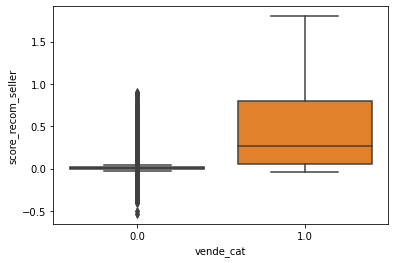

In [14]:
sns.boxplot(data = tb_eval_recom, x = 'vende_cat', y = 'score_recom_seller')

Vamos utilizar uma regressão logística para visualizar o impacto do score na probabilidade de compra.

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
log_fit = lm.LogisticRegression()
log_fit.fit(tb_eval_recom[['score_recom_seller']], tb_eval_recom['vende_cat'])
tb_eval_recom['pred_proba'] = log_fit.predict_proba(tb_eval_recom[['score_recom_seller']])[:,-1]

<AxesSubplot:xlabel='score_recom_seller', ylabel='pred_proba'>

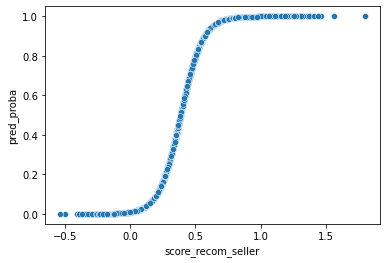

In [24]:
sns.scatterplot(data = tb_eval_recom, x = 'score_recom_seller', y = 'pred_proba')

## Construindo a decomposição de usuários
Da mesma forma que podemos decompor a matriz de usuários podemos decompor a matriz de itens: vamos transpor a matriz de usuário-itens e aplicar o mesmo processo - decompor as colunas dessa matriz. No entanto, nesta nova matriz as colunas são os diferentes sellers. Então ao invés de encontrar produtos que são correlatos entre si, encontraremos usuários que tem comportamento semelhante.

In [25]:
tb_cat = tb_seller_cat.pivot_table(values = 'vende_cat', index = 'product_category_name', columns = 'seller_id', aggfunc = 'sum', fill_value = 0).reset_index()
tb_cat.head()

seller_id,product_category_name,0015a82c2db000af6aaaf3ae2ecb0532,001cca7ae9ae17fb1caed9dfb1094831,001e6ad469a905060d959994f1b41e4f,002100f778ceb8431b7a1020ff7ab48f,004c9cd9d87a3c30c522c48c4fc07416,00720abe85ba0859807595bbf045a33b,00ab3eff1b5192e5f1a63bcecfee11c8,00d8b143d12632bad99c0ad66ad52825,00ee68308b45bc5e2660cd833c3f81cc,...,ff69aa92bb6b1bf9b8b7a51c2ed9cf8b,ff82e8873fba613f2261a9acc896fd84,ffa6adafb71b807dc13159e26431354c,ffad1e7127fb622cb64a900751590acd,ffc470761de7d0232558ba5e786e57b7,ffcfefa19b08742c5d315f2791395ee5,ffdd9f82b9a447f6f8d4b91554cc7dd3,ffeee66ac5d5a62fe688b9d26f83f534,fffd5413c0700ac820c7069d66d98c89,ffff564a4f9085cd26170f4732393726
0,agro_industria_e_comercio,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,alimentos,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,alimentos_bebidas,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,artes,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,artes_e_artesanato,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
tb_cat.drop('product_category_name', axis = 1).shape

(73, 3035)

Vamos aumentar o número de componentes pois o número de sellers é muito maior que o número de categorias

In [27]:
pca_fit = PCA(20)
tb_cat_pca = pca_fit.fit_transform(tb_cat.drop('product_category_name', axis = 1))

tb_cat_recom = pd.DataFrame(pca_fit.inverse_transform(tb_cat_pca), columns = tb_cat.columns[1:])
tb_cat_recom['product_category_name'] = tb_cat['product_category_name']
tb_cat_recom.head()

seller_id,0015a82c2db000af6aaaf3ae2ecb0532,001cca7ae9ae17fb1caed9dfb1094831,001e6ad469a905060d959994f1b41e4f,002100f778ceb8431b7a1020ff7ab48f,004c9cd9d87a3c30c522c48c4fc07416,00720abe85ba0859807595bbf045a33b,00ab3eff1b5192e5f1a63bcecfee11c8,00d8b143d12632bad99c0ad66ad52825,00ee68308b45bc5e2660cd833c3f81cc,00fc707aaaad2d31347cf883cd2dfe10,...,ff82e8873fba613f2261a9acc896fd84,ffa6adafb71b807dc13159e26431354c,ffad1e7127fb622cb64a900751590acd,ffc470761de7d0232558ba5e786e57b7,ffcfefa19b08742c5d315f2791395ee5,ffdd9f82b9a447f6f8d4b91554cc7dd3,ffeee66ac5d5a62fe688b9d26f83f534,fffd5413c0700ac820c7069d66d98c89,ffff564a4f9085cd26170f4732393726,product_category_name
0,0.034276,-0.000577,-0.003598,0.001198,-0.009878,0.014399,0.002873,-0.029688,0.008210,0.007634,...,-0.019338,-0.012541,-0.002345,0.057386,0.019456,0.015597,0.024282,0.032198,0.057835,agro_industria_e_comercio
1,0.009616,-0.019771,0.023096,-0.007251,-0.000436,-0.006146,0.041247,-0.050802,0.017703,-0.011925,...,-0.005081,0.026399,0.008754,0.076733,0.020662,-0.013397,0.015523,0.005273,0.028449,alimentos
2,-0.018512,-0.029249,0.013852,-0.005842,-0.002771,-0.001220,0.011584,-0.012365,0.019222,-0.008304,...,0.004858,0.010697,0.004903,-0.012212,0.026090,-0.007062,0.010906,0.018243,-0.001354,alimentos_bebidas
3,0.008824,0.008068,0.003193,0.018241,-0.004179,-0.003349,0.001265,-0.014594,0.015369,0.012878,...,-0.011309,0.002301,0.016201,0.041012,0.023202,0.014892,0.014550,0.034679,-0.003019,artes
4,-0.007936,-0.009661,-0.003914,0.002124,-0.002078,-0.006068,-0.001611,-0.003441,0.019058,-0.001951,...,-0.022542,-0.002627,-0.006072,-0.004402,0.025564,-0.003944,0.013370,0.019817,0.020319,artes_e_artesanato


In [28]:
tb_cat_seller_recom = tb_cat_recom.melt(id_vars = 'product_category_name').rename({'value' : 'score_recom_cat'}, axis = 1)
tb_cat_seller_recom.head()

,product_category_name,seller_id,score_recom_cat
0,agro_industria_e_comercio,0015a82c2db000af6aaaf3ae2ecb0532,0.034276
1,alimentos,0015a82c2db000af6aaaf3ae2ecb0532,0.009616
2,alimentos_bebidas,0015a82c2db000af6aaaf3ae2ecb0532,-0.018512
3,artes,0015a82c2db000af6aaaf3ae2ecb0532,0.008824
4,artes_e_artesanato,0015a82c2db000af6aaaf3ae2ecb0532,-0.007936


Agora, vamos agregar este novo score a nossa base original e comparar os dois scores e entender como podemos combina-los em um unico score de recomendação.

In [29]:
tb_eval_recom = tb_eval_recom.merge(tb_cat_seller_recom, on = ['seller_id', 'product_category_name'], how = 'left').fillna(0)

## Combinando as duas projeções
Agora temos dois scores de recomendação - um estimado a partir da semelhança entre categorias e outro a partir da semelhança entre usuários. Podemos combina-los de duas formas: de uma forma simples e direta ou utilizando um modelo.

In [30]:
tb_eval_recom.head()

,seller_id,product_category_name,score_recom_seller,rb,vende_cat,pred_proba,score_recom_cat
0,0015a82c2db000af6aaaf3ae2ecb0532,agro_industria_e_comercio,0.003531,0.0,0.0,0.010106,0.034276
1,001cca7ae9ae17fb1caed9dfb1094831,agro_industria_e_comercio,0.009781,0.0,0.0,0.010884,-0.000577
2,001e6ad469a905060d959994f1b41e4f,agro_industria_e_comercio,0.000894,0.0,0.0,0.009794,-0.003598
3,002100f778ceb8431b7a1020ff7ab48f,agro_industria_e_comercio,0.006626,0.0,0.0,0.010484,0.001198
4,004c9cd9d87a3c30c522c48c4fc07416,agro_industria_e_comercio,0.000867,0.0,0.0,0.009791,-0.009878


<AxesSubplot:xlabel='vende_cat', ylabel='score_recom_cat'>

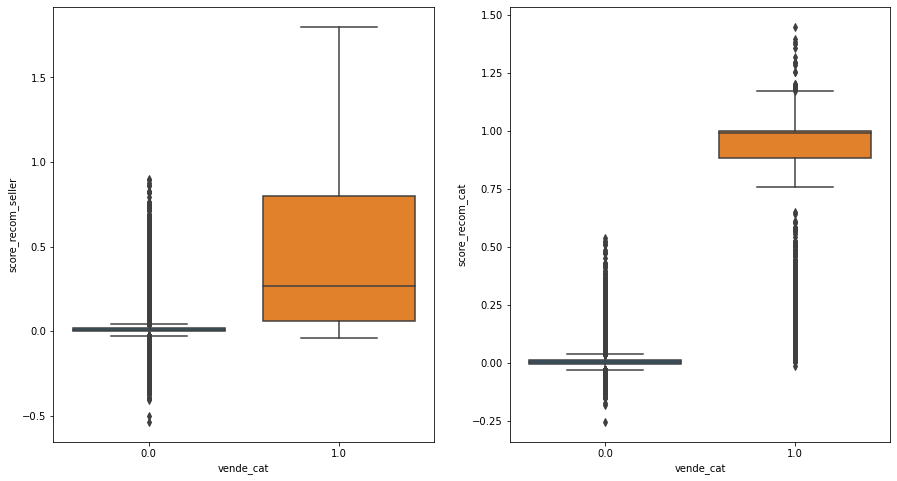

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (15, 8))
sns.boxplot(data = tb_eval_recom, x = 'vende_cat', y = 'score_recom_seller', ax = ax[0])
sns.boxplot(data = tb_eval_recom, x = 'vende_cat', y = 'score_recom_cat', ax = ax[1])

Vamos analisar o espaço composto pelos dois scores a luz da compra real.

<AxesSubplot:xlabel='score_recom_seller', ylabel='score_recom_cat'>

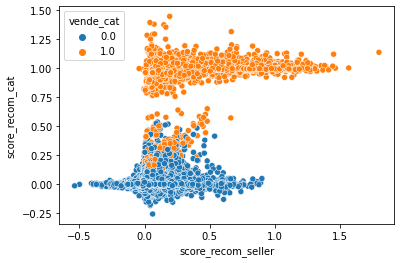

In [32]:
sns.scatterplot(data = tb_eval_recom, x = 'score_recom_seller', y = 'score_recom_cat', hue = "vende_cat")

### Utilizando o score máximo como métrica de recomendação

In [36]:
tb_eval_recom['max_score'] = tb_eval_recom.apply(lambda x: max(x['score_recom_seller'], x['score_recom_cat']), axis = 1)

In [37]:
log_fit = lm.LogisticRegression()
log_fit.fit(tb_eval_recom[['max_score']], tb_eval_recom['vende_cat'])
tb_eval_recom['pred_proba_max'] = log_fit.predict_proba(tb_eval_recom[['max_score']])[:,-1]

<AxesSubplot:xlabel='max_score', ylabel='pred_proba_full'>

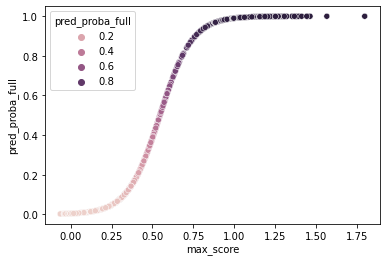

In [38]:
sns.scatterplot(data = tb_eval_recom, x = 'max_score', y = 'pred_proba_max', hue = 'pred_proba_full')

<AxesSubplot:xlabel='pred_proba', ylabel='pred_proba_max'>

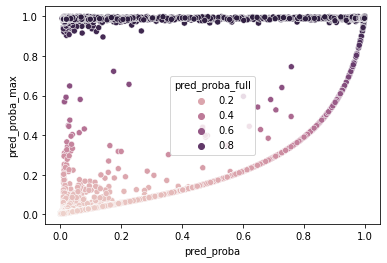

In [39]:
sns.scatterplot(data = tb_eval_recom, x = 'pred_proba', y = 'pred_proba_max', hue = 'pred_proba_full')

### Exercicio
Comparar o resultado da utilização do MÁX, como fizemos acima, com a utilização de duas regressões logísticas separadas - uma a partir do `score_recom_seller` e outra do `score_recom_cat`, gerando duas classificações binárias que são agregadas em 3 ou 4 categorias (indo de 0-0, 0-1, 1-0, 1-1)

### Utilizando a regressão logística para compor as duas variáveis de score

In [40]:
log_fit = lm.LogisticRegression()
log_fit.fit(tb_eval_recom[['score_recom_seller', 'score_recom_cat']], tb_eval_recom['vende_cat'])
tb_eval_recom['pred_proba_full'] = log_fit.predict_proba(tb_eval_recom[['score_recom_seller', 'score_recom_cat']])[:,-1]

<AxesSubplot:xlabel='score_recom_seller', ylabel='score_recom_cat'>

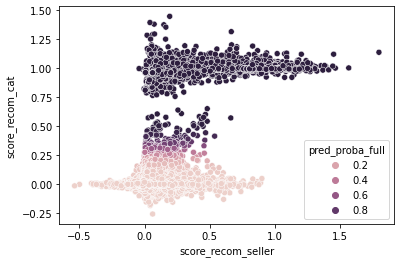

In [41]:
sns.scatterplot(data = tb_eval_recom, x = 'score_recom_seller', y = 'score_recom_cat', hue = 'pred_proba_full')

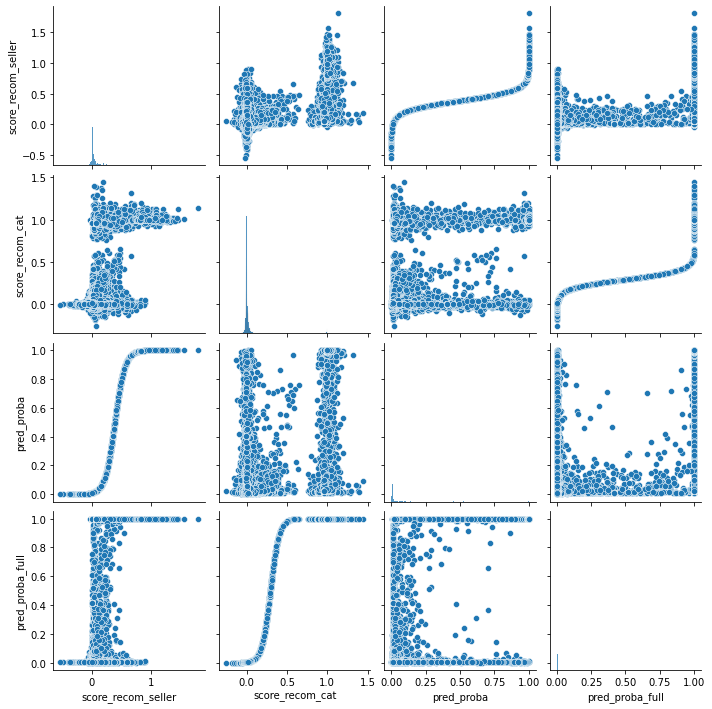

In [42]:
sns.pairplot(data = tb_eval_recom, 
             vars = ['score_recom_seller', 'score_recom_cat', 'pred_proba', 'pred_proba_full'])

## Exercício

O modelo construído acima pode ser melhorado se utilizarmos a função de decomposição NMF no lugar da função PCA. Consolide as etapas percorridas acima trocando o PCA por NMF.

# Utilizando a biblioteca Suprise!
Essa forma que vimos acima é bem proxima de como os algoritmos de ponta para sistemas de recomendação. O que muda são as forma de decomposição e de realizar a estimativa da probabilidade de compra a partir dos scores da decomposição matricial. A biblioteca `scikit-suprise` contém implementações dos algoritmos mais modernos, utilizando SVD e kNN como estimadores de recomendação por exemplo.

Toda essa familia de decomposições tornou-se o padrão na indústria a partir de 2006, quando o cientista de dado Simon Funk venceu a competição para o sistema de recomendação do Netflix.

In [43]:
from surprise import SVD, Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split, cross_validate

In [44]:
reader = Reader(rating_scale = (0, 1))

In [45]:
tb_seller_cat['rating'] = np.where(tb_seller_cat['rb'] > 0, 1, 0)
tb_scf = tb_seller_cat[['seller_id', 'product_category_name', 'rating']].rename({'seller_id' : 'userID', 'product_category_name' : 'itemID'}, axis = 1).copy()

In [46]:
tb_scf

,userID,itemID,rating
0,66dc1b1632bd6a3e508510c5b3492107,automotivo,1
1,4e42581f08e8cfc7c090f930bac4552a,moveis_decoracao,1
2,2c9e548be18521d1c43cde1c582c6de8,artigos_de_festas,1
3,a673821011d0cec28146ea42f5ab767f,cama_mesa_banho,1
4,59cea8e446d3834393058e7e0666b6fb,informatica_acessorios,1
...,...,...,...
6611,dfa0c4c6229ab200a4a1336b4d7128ff,utilidades_domesticas,1
6612,57fe6232e67823593374a2281d7a8af8,NaN,1
6613,0af2ab31141893d26aca5a404a537dab,informatica_acessorios,1
6614,8cc6a0e5738e61a87b03c78b2ba9db4b,cool_stuff,1


In [47]:
data = Dataset.load_from_df(tb_scf, reader)

In [48]:
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0421  0.0419  0.0396  0.0395  0.0416  0.0409  0.0011  
MAE (testset)     0.0190  0.0193  0.0188  0.0181  0.0197  0.0190  0.0005  
Fit time          0.28    0.26    0.26    0.26    0.26    0.27    0.01    
Test time         0.01    0.01    0.00    0.00    0.00    0.01    0.00    


{'test_rmse': array([0.04209114, 0.04187512, 0.03964196, 0.03945129, 0.04161708]),
 'test_mae': array([0.01903971, 0.01925329, 0.01882959, 0.01812036, 0.01966855]),
 'fit_time': (0.28192782402038574,
  0.2628772258758545,
  0.2627718448638916,
  0.2610208988189697,
  0.2602498531341553),
 'test_time': (0.006304025650024414,
  0.0052852630615234375,
  0.004845857620239258,
  0.00481724739074707,
  0.004884004592895508)}

In [50]:
predictions = algo.test(testset)

In [51]:
predictions[0:5]

[Prediction(uid='43f8c9950d11ecd03a0304a49e010da6', iid='consoles_games', r_ui=1.0, est=1, details={'was_impossible': False}),
 Prediction(uid='f5b84683a9bf9e1df748cf40f601b39c', iid='bebes', r_ui=1.0, est=0.9307818872467686, details={'was_impossible': False}),
 Prediction(uid='e6a69c4a27dfdd98ffe5aa757ad744bc', iid='moveis_decoracao', r_ui=1.0, est=0.9786970785665537, details={'was_impossible': False}),
 Prediction(uid='57fe6232e67823593374a2281d7a8af8', iid='livros_interesse_geral', r_ui=1.0, est=0.9314558295115762, details={'was_impossible': False}),
 Prediction(uid='e1c76f339ebd5460999f25a2aa8c92c5', iid='eletroportateis', r_ui=1.0, est=0.9918700592842539, details={'was_impossible': False})]

In [ ]:
type(predictions[0])

## Exercício

Investigue os parâmetros que podemos utilizar na construção do modelo SVD. Como você otimizaria esses parâmetros? Leia a documentação da biblioteca `scikit-surprise` para entender melhor como este modelo funciona. Como podemos incluir informações como a região do seller, ou o preço médio do item? Será que conseguimos tratar a venda como algo não binário (uma escala de não vende, vende pouco, vende muito por exemplo)?